In [1]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,vcat([2],18:32)]
dat1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,17]
dat2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2.csv",DataFrame)[:,33]
dat[:,2:end] .= log.(dat[:,2:end] .+ 1e-2)
dat[1:4,:]

Row,year,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449,lat_36_09899,lat_36_10349,lat_36_10799,lat_36_11249,lat_36_11698,lat_36_12148,lat_36_12598,lat_36_13048,lat_36_13498,lat_36_13948
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,-1.20027,-1.94119,-1.03678,-3.6812,-4.60517,-2.11977,-0.804252,-1.58474,-1.26537,-4.60517,-1.63233,-1.64554,-3.99349,-1.54454,-1.5023
2,1985,-0.204018,-0.0798734,0.00995033,-0.143568,-2.46943,-0.270178,0.00995033,0.00995033,0.00995033,-0.360923,0.00995033,0.00995033,-0.972054,0.00995033,-0.0189833
3,1986,-1.83918,-1.09126,-1.98384,-1.46933,-4.07004,-1.38429,-1.06248,-0.923027,-0.944995,-4.2058,-1.92127,-1.7083,-2.88632,-1.65098,-1.98705
4,1987,-0.796447,-0.757462,-0.825752,-2.17458,-3.33211,-1.30186,-0.760597,-0.94546,-1.07241,-1.57449,-1.05118,-1.04158,-2.51289,-1.23411,-1.34993


In [ ]:
dat_K = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,18:32]
K1 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,17]
K2 = CSV.read("../processed_data/kelp_bins_50_500m_cenca_model_2_K.csv",DataFrame)[:,33]
K = Matrix(dat_K)[1,:]
dat_K

Row,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449,lat_36_09899,lat_36_10349,lat_36_10799,lat_36_11249,lat_36_11698,lat_36_12148,lat_36_12598,lat_36_13048,lat_36_13498,lat_36_13948
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.117662,0.159898,0.0872487,0.0622901,0.207159,0.246416,0.117871,0.210307,0.125227,0.0990655,0.389051,0.330936,0.366467,0.424368,0.114307


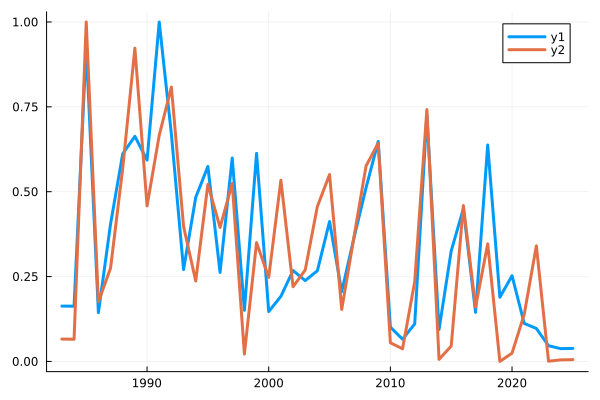

In [4]:
using Statistics
mu_t1 = dat1
mu_t1 = vcat([mean(mu_t1)],mu_t1,[mean(mu_t1)])
years = vcat([1500],dat.year, [2500])

mu_t2 = dat2
mu_t2 = vcat([mean(mu_t2)],mu_t2,[mean(mu_t2)])
years = vcat([1500],dat.year, [2500])

function mu(t,mu_t)
    ind_lower = maximum(eachindex(years)[years .<= t])
    ind_upper = minimum(eachindex(years)[years .> t])
    t_lower = years[ind_lower]
    t_upper = years[ind_upper]
    mu_lower = mu_t[ind_lower]
    mu_upper = mu_t[ind_upper]

    mu = mu_lower + (t-t_lower)/(t_upper-t_lower)*(mu_upper-mu_lower)
    return mu
end 
tvals = 1983:0.25:2025
Plots.plot(tvals, broadcast(t ->mu(t,mu_t1), tvals), linewidth = 3)
Plots.plot!(tvals, broadcast(t ->mu(t,mu_t2), tvals), linewidth = 3)

In [5]:
X = CSV.read("../processed_data/covars.csv",DataFrame)[:,:2:end]
X[1:4,:]

Row,year,variable,value
,Float64,String7,Float64
1,1980.0,enso,0.33
2,1980.08,enso,0.2
3,1980.17,enso,0.39
4,1980.25,enso,0.51


In [6]:
include("../src/UDE3.jl")
model, NN = init_model(dat,X,K,t -> mu(t,mu_t1),t -> mu(t,mu_t2),K1,K2,1,[2];hidden = 10)
nothing

In [7]:
function training!(model,reg_weight)
α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", regularization_weight = reg_weight, 
        optim_options = (maxiter = 500, step_size = 0.05), loss_options = (σ = 0.05^2, τ = 0.05^2, T = 160))
end
training!(model,1e4)
nothing

162
3.15603826434e8 3.53843367847e8 3.17783616345e8 3.44293984317e8 3.24319622869e8 3.12532432361e8 3.21334356119e8 3.27944422084e8 3.19030151682e8 3.08024115384e8 3.08833542428e8 3.14206973029e8 3.09778252507e8 3.0166138411e8 3.02693554413e8 3.05955083178e8 3.00969180435e8 2.95985232139e8 2.96669373979e8 2.95707371678e8 2.90931498969e8 2.87987606509e8 2.87547544357e8 2.85338501223e8 2.81115076244e8 2.78432724181e8 2.77176362978e8 2.74271539052e8 2.70563229603e8 2.68346855886e8 2.66267998323e8 2.62974180822e8 2.60006194625e8 2.57749141804e8 2.55014496854e8 2.52050396163e8 2.4925472641e8 2.46794273652e8 2.43880229592e8 2.4107335242e8 2.38476116272e8 2.35788445538e8 2.32936206197e8 2.30350504435e8 2.27622636088e8 2.24942264337e8 2.2227403865e8 2.19588694e8 2.16964094074e8 2.14386659987e8 2.11751567217e8 2.09101246025e8 2.06490448168e8 2.03952341664e8 2.0166024935e8 2.00235736927e8 1.98614326162e8 1.94092916613e8 1.92645932456e8 1.90265863041e8 1.86856263734e8 1.85854150847e8 1.8221329172

In [8]:
using JLD2
save_object("../results/parameters/model2_0.05_1e4.jld",model.parameters)

In [9]:
rhs = UniversalDiffEq.get_right_hand_side(model)
f_rhs = (u,X,site) -> rhs(zeros(length(K)) .+ u  , [X,X], 2000.0)[site]
f_rhs(0.0,0.0,2)

0.0

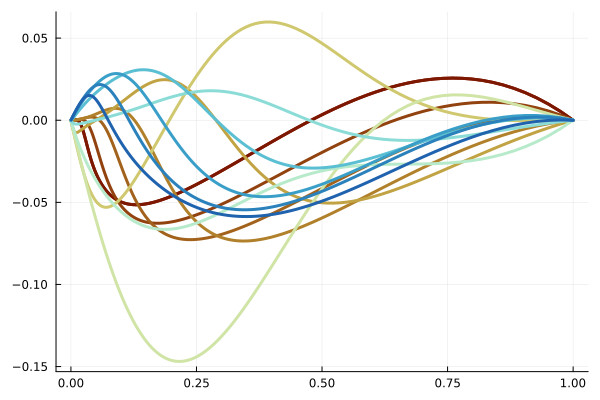

In [14]:
Xvals = -3:0.5:3; site = 12
uvals = -8.0:0.025:0.0
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(exp.(uvals),exp.(uvals).*f_rhs.(uvals,Xvals[1],site), color = colors[1], label = "",width=3)
i = 0
for X in Xvals
    i += 1
    Plots.plot!(p1,exp.(uvals),exp.(uvals).*f_rhs.(uvals,X,site), color = colors[i], label = "",width=3)
end
p1

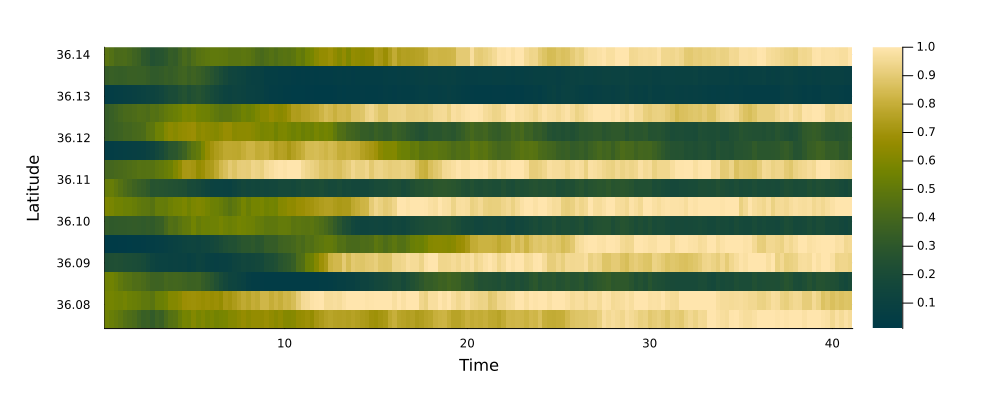

In [25]:
u = model.parameters.uhat[:,1]
X = [0.0,0.0] .+ -2.0
T = 2025-1984
dt = 0.25
uvals = zeros(length(K), round(Int,T/dt))
i = 0
for t in (1984+dt):dt:2025
    i+=1
    u[u.>0] .= 0
    uvals[:,i] = u
    X = model.process_model.covariates(t)
    u = u + dt*rhs(u,X,t).+sqrt(dt)*0.05*randn(length(K))
end

function get_latitude(nm)
m = match(r"(?<integer>\d+)_(?<decimal>\d+)",nm)
parse(Float64,(m[:integer])) + parse(Float64,(string("0.",m[:decimal])))
end 

lats = get_latitude.(names(dat[:,2:end]))

using Plots.PlotMeasures
Plots.heatmap(dt:dt:T,lats,exp.(uvals), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

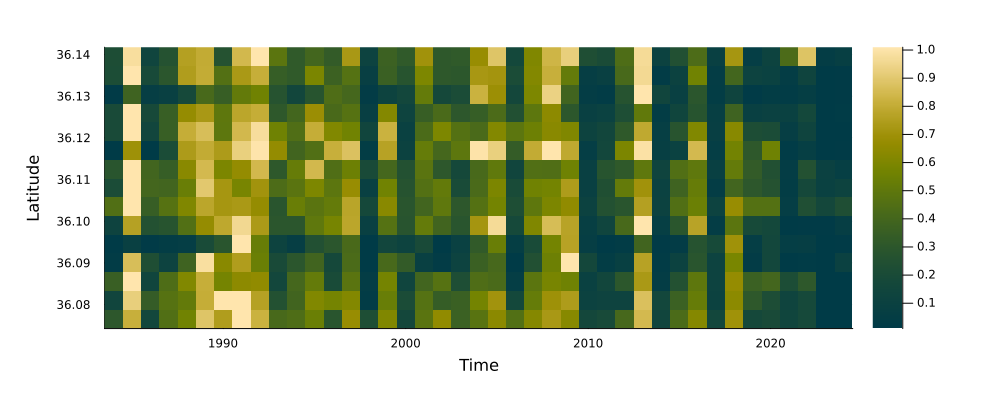

In [16]:
Plots.heatmap(dat.year,lats,exp.(Matrix(dat[:,2:end]))', c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)

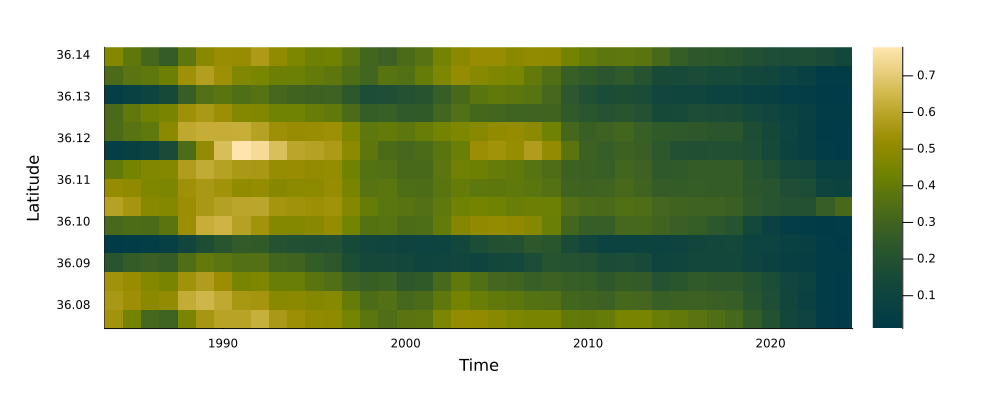

In [17]:
Plots.heatmap(dat.year,lats,exp.(Matrix(model.parameters.uhat)), c= :bamako, size = (1000,400),
ylabel = "Latitude", xlabel = "Time", margin = 10mm)